In [1]:
from hfunc import preprocessing
import tensorflow as tf
import pathlib
import os
import copy
import numpy as np
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import tensorflow.keras as keras
from keras.backend import clear_session
import gc

# Reset Keras Session
def reset_keras():
    clear_session()
    print(gc.collect())
    print(gc.collect())

Using TensorFlow backend.


In [3]:
import glob

def remove_logs(log_dir):
    files = glob.glob(log_dir)
    for f in files:
        os.remove(f)

In [4]:
DIR_PATH = pathlib.Path(
    'C:\\Users\\lucas\\Documents\\Masters\\data\\kvasir-dataset-v2'
)

ds = preprocessing.load_dataset_images(DIR_PATH, 224, 224)

for image, label in ds.take(8):
    print("Image shape:", image.numpy().shape)
    print('Label:', label.numpy())

del image, label

train_ds, val_ds, test_ds = preprocessing.train_val_test_split(
    ds,
    0.7,
    0.15
)

cachefile = "C:\\Users\\lucas\\Documents\\Masters\\cache\\kvasir"

train_ds = preprocessing.prepare_for_model_use(
    train_ds,
    cache=cachefile+'_train',
    prefetch=True
)
val_ds = preprocessing.prepare_for_model_use(
    val_ds,
    cache=cachefile+'_val',
    shuffle=False,
    repeat=False
)
test_ds = preprocessing.prepare_for_model_use(
    test_ds,
    cache=cachefile+'_test',
    shuffle=False,
    repeat=False
)

Image shape: (224, 224, 3)
Label: [ True False False False False False False False]
Image shape: (224, 224, 3)
Label: [False  True False False False False False False]
Image shape: (224, 224, 3)
Label: [False False  True False False False False False]
Image shape: (224, 224, 3)
Label: [False False False  True False False False False]
Image shape: (224, 224, 3)
Label: [False False False False  True False False False]
Image shape: (224, 224, 3)
Label: [False False False False False  True False False]
Image shape: (224, 224, 3)
Label: [False False False False False False  True False]
Image shape: (224, 224, 3)
Label: [False False False False False False False  True]


In [5]:
ind = 14

In [6]:
ind += 1
np.random.seed(2020)
vgg16 = tf.keras.applications.VGG16(weights=None, classes=8)

In [7]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
adam = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.8, beta_2=0.9)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5, nesterov=True)
vgg16.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
earl_stop = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/model_{ind}")

In [10]:
reset_keras()
if not os.path.isfile('./weights/my_weights.index'):
    hist = vgg16.fit(train_ds, epochs=200, validation_data=val_ds, steps_per_epoch=175, validation_steps=35, callbacks=[tensorboard_callback, earl_stop], use_multiprocessing=True)

6410
0


In [11]:
import copy
def estimate_node_importance(model, tester_model, layer_sizes, tol_low, tol_high, data, folder_path):
    
    l, a = model.evaluate(data, verbose=0, steps=38)
    or_weights = model.get_weights()
    weight_len = len(or_weights) - 3
    amounts = []
    places = []
    
    if folder_path:
        # Retriving Zero Nodes
        try:
            r = open(folder_path+'/zero.txt', 'r')
            temp_z = [list(map(int,line.split())) for line in r.readlines()]
            r.close()
        except:
            print('No Zero file')
            temp_z = []
        # Retriving Important Nodes
        try:
            r = open(folder_path+'/important.txt', 'r')
            temp_imp = [list(map(int,line.split())) for line in r.readlines()]
        except:
            print("No Important File")
            temp_imp = []
        # Retriving Worse Nodes
        try:
            r = open(folder_path+'/worse.txt', 'r+')
            temp_wr = [list(map(int,line.split())) for line in r.readlines()]
            r.close()
        except:
            print("No Worse File")
            temp_wr = []
    
    for layer, size in enumerate(layer_sizes):
        
        if folder_path and layer < len(temp_z):
            z = temp_z[layer]
            wr = temp_wr[layer]
            imp = temp_imp[layer]
            num_zeros = len(z)
            num_worse = len(wr)
            num_important = len(imp)
            done = (num_zeros + num_worse + num_important)
        else:
            num_zeros, num_worse, num_important = (0, 0, 0)
            z = []
            wr = []
            imp = []
            done = 0
            
        print(f'Layer {len(layer_sizes)-layer}')
        for i in range(size):
            if i == 0:
                if done == size:
                    break
                else:
                    i += done
            w = copy.deepcopy(or_weights)
            w[weight_len - (2*layer+1)][...,i] = 0
            w[weight_len - 2*layer][i] = 0
            tester_model.set_weights(w)
            nl, na = tester_model.evaluate(data, verbose=0, steps=38)
            change = l - nl
            print(f'Node {i}: {change}')
            if change <= tol_high and change >= tol_low:
                num_zeros += 1
                z += [i]
                if folder_path:
                    f = open(folder_path+'/zero.txt', 'a+')
                    f.write(str(i)+" ")
                    f.close()
            elif change > 0:
                num_worse += 1
                wr += [i]
                if folder_path:
                    f = open(folder_path+'/worse.txt', 'a+')
                    f.write(str(i)+" ")
                    f.close()
            else:
                num_important += 1
                imp += [i]
                if folder_path:
                    f = open(folder_path+'/important.txt', 'a+')
                    f.write(str(i)+" ")
                    f.close()
        if folder_path:
            f = open(folder_path+'/zero.txt', 'a+')
            f.write("\n")
            f.close()
            f = open(folder_path+'/worse.txt', 'a+')
            f.write("\n")
            f.close()
            f = open(folder_path+'/important.txt', 'a+')
            f.write("\n")
            f.close()
        amounts.append((num_zeros, num_worse, num_important))
        places.append((z, wr, imp))
    
    return amounts, places

In [12]:
if not os.path.isfile('./weights/my_weights.index'):
    vgg16.save_weights('./weights/my_weights')
else:
    vgg16.load_weights('./weights/my_weights')

In [13]:
vgg16.evaluate(test_ds, steps=38)

38/38 [==============================] - 4s 112ms/step - loss: 0.4099 - accuracy: 0.8725


[0.40989330410957336, 0.8725000023841858]

In [14]:
layer_sizes = [4096, 4096, 512, 512, 512, 512, 512, 512, 256, 256, 256, 128, 128, 64, 64]
vgg16_test = tf.keras.applications.VGG16(weights=None, classes=8)
vgg16_test.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
th = 1e-5
tl = -1e-5

In [15]:
th = 1e-5
tl = -1e-5
reset_keras()
amounts, places = estimate_node_importance(vgg16, vgg16_test, layer_sizes, tl, th, val_ds, 'Estimate')

41
0
Layer 15
Layer 14
Layer 13
Layer 12
Layer 11
Layer 10
Layer 9
Layer 8
Layer 7
Layer 6
Layer 5
Layer 4
Layer 3
Layer 2
Layer 1


In [16]:
for i, (nz, nw, ni) in enumerate(reversed(amounts)):
    print(f'######### LAYER {i+1} #########')
    print("Zero Nodes:", nz)
    print("Worse Nodes:", nw)
    print("Important Nodes:", ni)

######### LAYER 1 #########
Zero Nodes: 14
Worse Nodes: 16
Important Nodes: 34
######### LAYER 2 #########
Zero Nodes: 17
Worse Nodes: 22
Important Nodes: 25
######### LAYER 3 #########
Zero Nodes: 30
Worse Nodes: 42
Important Nodes: 56
######### LAYER 4 #########
Zero Nodes: 34
Worse Nodes: 47
Important Nodes: 47
######### LAYER 5 #########
Zero Nodes: 88
Worse Nodes: 93
Important Nodes: 75
######### LAYER 6 #########
Zero Nodes: 73
Worse Nodes: 98
Important Nodes: 85
######### LAYER 7 #########
Zero Nodes: 79
Worse Nodes: 92
Important Nodes: 85
######### LAYER 8 #########
Zero Nodes: 139
Worse Nodes: 175
Important Nodes: 198
######### LAYER 9 #########
Zero Nodes: 137
Worse Nodes: 193
Important Nodes: 182
######### LAYER 10 #########
Zero Nodes: 84
Worse Nodes: 206
Important Nodes: 222
######### LAYER 11 #########
Zero Nodes: 52
Worse Nodes: 189
Important Nodes: 271
######### LAYER 12 #########
Zero Nodes: 28
Worse Nodes: 202
Important Nodes: 282
######### LAYER 13 #########
Zero Nod

In [17]:
def node_pruning(model, tester_model, data, layer_sizes, tol, ignore_cutoff, method='exhaustive', folder_path=None):

    loss, acc = model.evaluate(data, verbose=0, steps=38)
    original = model.get_weights()
    weight_len = len(original) - 3
    bas = [acc]
    bls = [loss]
    best_weights = model.get_weights()
    best_acc = 0
    best_loss = 1e20
    ol = loss
    oa = acc
    amounts = []
    places = []
    
    if folder_path:
        # Retriving Nodes removed
        try:
            r = open(folder_path+'/removed.txt', 'r')
            temp_remove = [list(map(int,line.split())) for line in r.readlines()]
            r.close()
        except:
            print('No node removal file')
            temp_remove = []
        # Retriving loss
        try:
            r = open(folder_path+'/loss.txt', 'r')
            bls = list(map(np.double,r.readline().split()))
            ol = bls[-1]
            r.close()
        except:
            print("No Loss File")
            f_loss = open(folder_path+'/loss.txt', "a+")
            bls = [loss]
            f_loss.write(str(loss)+' ')
            f_loss.close()
        # Retriving accuracy
        try:
            r = open(folder_path+'/accuracy.txt', 'r+')
            bas = r.readline().split()
            bas = list(map(np.double,bas))
            oa = bas[-1]
            r.close()
        except:
            print("No Accuracy File")
            f_acc = open(folder_path+'/accuracy.txt', "a+")
            bas = [acc]
            f_acc.write(str(acc)+' ')
            f_acc.close()
        # Retriving best weights
        try:
            tester_model.load_weights(folder_path+'/weights')
            best_weights = tester_model.get_weights()
        except:
            print('No weights found')
        

    for layer, size in enumerate(layer_sizes):
        if folder_path and layer < len(temp_remove):
            nodes_removed = temp_remove[layer]
            num_removed = len(nodes_removed)
            if layer + 1 < len(temp_remove):
                end_not_reached = False
            else:
                end_not_reached = True
        else:
            num_removed = 0
            nodes_removed = []
            end_not_reached = True
        print(f'Starting removal in Layer {len(layer_sizes) - layer}')
        if method == 'exhaustive':
            current_pos = 0
            best_change = tol
            best_pos = -1
            improved = False
            while end_not_reached or improved:
                if not(end_not_reached):
                    end_not_reached = True
                    improved = False
                    current_pos = 0
                    size -= 1
                    nodes_removed += [best_pos]
                    best_weights[weight_len - (2*layer+1)][...,best_pos] = 0
                    best_weights[weight_len - 2*layer][best_pos] = 0
                    best_pos = -1
                    ol = best_loss
                    oa = best_acc
                    bas += [best_acc]
                    bls += [best_loss]
                    best_change = tol
                    num_removed += 1
                if current_pos in nodes_removed:
                    current_pos += 1
                    if current_pos - num_removed >= size:
                        end_not_reached = False
                    continue
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(data, verbose=0, steps=38)
                if ol - nl >= best_change:
                    best_change = ol - nl
                    best_pos = current_pos
                    improved = True
                    best_acc = na
                    best_loss = nl
                current_pos += 1
                if current_pos - num_removed >= size:
                    end_not_reached = False
        elif method == 'greedy':
            nodes_to_estimate = list(np.arange(size))
            if folder_path and layer < len(temp_remove):
                for i in nodes_removed:
                    nodes_to_estimate.remove(i)
                size -= num_removed
            current_pos = nodes_to_estimate[0]
            idx = 0
            while end_not_reached:
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(data, verbose=0, steps=38, workers=12, use_multiprocessing=True)
                print(f'Node {current_pos}: {ol - nl}')
                if ol - nl >= tol:
                    oa = na
                    ol = nl
                    size -= 1
                    nodes_removed += [current_pos]
                    nodes_to_estimate.remove(current_pos)
                    best_weights[weight_len - (2*layer+1)][..., current_pos] = 0
                    best_weights[weight_len - 2*layer][current_pos] = 0
                    bas += [oa]
                    bls += [ol]
                    num_removed += 1
                    idx = 0
                    if folder_path:
                        f_rem = open(folder_path+'/removed.txt', "a+")
                        f_loss = open(folder_path+'/loss.txt', "a+")
                        f_acc = open(folder_path+'/accuracy.txt', "a+")
                        
                        f_rem.write(str(current_pos) + ' ')
                        f_loss.write(str(ol) + ' ')
                        f_acc.write(str(oa) + ' ')
                        
                        f_rem.close()
                        f_loss.close()
                        f_acc.close()
                        
                        tester_model.save_weights(folder_path+'/weights')
                elif ol - nl <= ignore_cutoff:
                    size -= 1
                    nodes_to_estimate.remove(current_pos)
                else:
                    idx += 1
                if idx >= size:
                    end_not_reached = False
                    if folder_path:
                        f_rem = open(folder_path+'/removed.txt', "a+")
                        f_rem.write('\n')
                        f_rem.close()
                else:
                    current_pos = nodes_to_estimate[idx]
        elif method == 'greedy_fast':
            improved = False
            nodes_to_estimate = list(np.arange(size))
            if folder_path and layer < len(temp_remove):
                for i in nodes_removed:
                    nodes_to_estimate.remove(i)
                size -= num_removed
            current_pos = nodes_to_estimate[0]
            idx = 0
            while end_not_reached:
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(data, verbose=0, steps=38, workers=12, use_multiprocessing=True)
                print(f'Node {current_pos}: {ol - nl}')
                if ol - nl >= tol:
                    oa = na
                    ol = nl
                    size -= 1
                    nodes_removed += [current_pos]
                    nodes_to_estimate.remove(current_pos)
                    best_weights[weight_len - (2*layer+1)][..., current_pos] = 0
                    best_weights[weight_len - 2*layer][current_pos] = 0
                    bas += [oa]
                    bls += [ol]
                    num_removed += 1
                    if folder_path:
                        f_rem = open(folder_path+'/removed.txt', "a+")
                        f_loss = open(folder_path+'/loss.txt', "a+")
                        f_acc = open(folder_path+'/accuracy.txt', "a+")
                        
                        f_rem.write(str(current_pos) + ' ')
                        f_loss.write(str(ol) + ' ')
                        f_acc.write(str(oa) + ' ')
                        
                        f_rem.close()
                        f_loss.close()
                        f_acc.close()
                        
                        tester_model.save_weights(folder_path+'/weights')
                elif ol - nl <= ignore_cutoff:
                    size -= 1
                    nodes_to_estimate.remove(current_pos)
                else:
                    idx += 1
                if idx >= size:
                    if improved:
                        idx = 0
                        current_pos = nodes_to_estimate[idx]
                    else:
                        end_not_reached = False
                        if folder_path:
                            f_rem = open(folder_path+'/removed.txt', "a+")
                            f_rem.write('\n')
                            f_rem.close()
                else:
                    current_pos = nodes_to_estimate[idx]
        print(f'Removed {num_removed} nodes for Layer {len(layer_sizes) - layer}')
        amounts.append(num_removed)
        places.append(nodes_removed)
    
    #if folder_path:
        #f_rem.close()
        #f_loss.close()
        #f_acc.close()
    
    return best_weights, bas, bls, amounts, places

In [18]:
reset_keras()
best_weights, bas, bls, amounts, places = node_pruning(vgg16, vgg16_test, val_ds, layer_sizes, tl, -5e-5, method='greedy', folder_path='.\Pruning')

124
0
Starting removal in Layer 15
Removed 2334 nodes for Layer 15
Starting removal in Layer 14
Removed 1337 nodes for Layer 14
Starting removal in Layer 13
Removed 33 nodes for Layer 13
Starting removal in Layer 12
Removed 88 nodes for Layer 12
Starting removal in Layer 11
Removed 109 nodes for Layer 11
Starting removal in Layer 10
Removed 143 nodes for Layer 10
Starting removal in Layer 9
Removed 186 nodes for Layer 9
Starting removal in Layer 8
Removed 170 nodes for Layer 8
Starting removal in Layer 7
Removed 84 nodes for Layer 7
Starting removal in Layer 6
Removed 94 nodes for Layer 6
Starting removal in Layer 5
Removed 96 nodes for Layer 5
Starting removal in Layer 4
Removed 47 nodes for Layer 4
Starting removal in Layer 3
Removed 46 nodes for Layer 3
Starting removal in Layer 2
Removed 25 nodes for Layer 2
Starting removal in Layer 1
Removed 21 nodes for Layer 1


In [19]:
vgg16_test.load_weights('./Pruning/weights')
vgg16_test.evaluate(test_ds, steps=38)

38/38 [==============================] - 3s 86ms/step - loss: 0.4103 - accuracy: 0.8467


[0.4103316366672516, 0.846666693687439]

In [20]:
vgg16.evaluate(test_ds, steps=38)

38/38 [==============================] - 3s 86ms/step - loss: 0.4099 - accuracy: 0.8725


[0.40989330410957336, 0.8725000023841858]

In [21]:
vgg16_test.evaluate(val_ds, steps=38)

38/38 [==============================] - 3s 86ms/step - loss: 0.1920 - accuracy: 0.9625 1s - loss:


[0.1919776350259781, 0.9624999761581421]

In [22]:
vgg16.evaluate(val_ds, steps=38)

38/38 [==============================] - 3s 86ms/step - loss: 0.3570 - accuracy: 0.8817


[0.3569997251033783, 0.8816666603088379]

In [23]:
vgg16_test.evaluate(train_ds, steps=175)

175/175 [==============================] - 16s 89ms/step - loss: 0.2818 - accuracy: 0.9034


[0.2817622125148773, 0.9033928513526917]

In [24]:
vgg16.evaluate(train_ds, steps=175)

175/175 [==============================] - 16s 90ms/step - loss: 0.1371 - accuracy: 0.9554


[0.13711915910243988, 0.9553571343421936]

In [25]:
amounts

[2334, 1337, 33, 88, 109, 143, 186, 170, 84, 94, 96, 47, 46, 25, 21]

In [26]:
bls_val = bls
bas_val = bas

In [27]:
otel, otea = vgg16.evaluate(test_ds, steps=38)
otrl, otra = vgg16.evaluate(train_ds, steps=175)

try:
    r = open('Evolution/loss_train.txt', 'r')
    bls_train = list(map(np.double,r.readline().split()))
    num_rem_train_loss = len(bls_train) - 1
    r.close()
except:
    print("No Train Loss File")
    f_loss = open('Evolution/loss_train.txt', "a+")
    bls_train = [otrl]
    f_loss.write(str(otrl)+' ')
    f_loss.close()
    num_rem_train_loss = 0
try:
    r = open('Evolution/loss_test.txt', 'r')
    bls_test = list(map(np.double,r.readline().split()))
    num_rem_test_loss = len(bls_test) - 1
    r.close()
except:
    print("No Test Loss File")
    f_loss = open('Evolution/loss_test.txt', "a+")
    bls_test = [otel]
    f_loss.write(str(otel)+' ')
    f_loss.close()
    num_rem_test_loss = 0
# Retriving accuracy
try:
    r = open('Evolution/accuracy_train.txt', 'r+')
    bas_train = r.readline().split()
    bas_train = list(map(np.double,bas_train))
    num_rem_train_acc = len(bas_train) - 1
    r.close()
except:
    print("No Train Accuracy File")
    f_acc = open('Evolution/accuracy_train.txt', "a+")
    bas_train = [otra]
    f_acc.write(str(otra)+' ')
    f_acc.close()
    num_rem_train_acc = 0
try:
    r = open('Evolution/accuracy_test.txt', 'r+')
    bas_test = r.readline().split()
    bas_test = list(map(np.double,bas_test))
    num_rem_test_acc = len(bas_test) - 1
    r.close()
except:
    print("No Test Accuracy File")
    f_acc = open('Evolution/accuracy_test.txt', "a+")
    bas_test = [otea]
    f_acc.write(str(otea)+' ')
    f_acc.close()
    num_rem_test_acc = 0

w = vgg16.get_weights()
weight_len = len(w) - 3
test = (num_rem_test_acc + num_rem_test_loss + num_rem_train_acc + num_rem_train_loss) - 4 * sum(amounts)
if test:
    for layer, layer_place in enumerate(places):
        print(f"Starting removal in layer {len(places) - layer}")
        for i, place in enumerate(layer_place):
            if i % 100 == 0:
                print(f'Removed {i} nodes!')
            w[weight_len - (2*layer+1)][..., place] = 0
            w[weight_len - 2*layer][place] = 0
            vgg16_test.set_weights(w)

            if num_rem_test_loss:
                if num_rem_test_acc:
                    num_rem_test_acc -= 1
                    #print('Double Test')
                else:
                    _, tea = vgg16_test.evaluate(test_ds, steps=38, verbose=0)
                    bas_test += [tea]
                    f = open('Evolution/accuracy_test.txt', "a")
                    f.write(str(tea)+' ')
                    f.close()
                    print('Loss Test only')
                num_rem_test_loss -= 1
            else:
                if num_rem_test_acc:
                    num_rem_test_acc -= 1
                    tel, _ = vgg16_test.evaluate(test_ds, steps=38, verbose=0)
                    bls_test += [tel]
                    print('Accuracy Test only')
                else:
                    tel, tea = vgg16_test.evaluate(test_ds, steps=38, verbose=0)
                    bls_test += [tel]
                    bas_test += [tea]
                    f = open('Evolution/accuracy_test.txt', "a")
                    f.write(str(tea)+' ')
                    f.close()
                f = open('Evolution/loss_test.txt', "a")
                f.write(str(tel)+' ')
                f.close()

            if num_rem_train_loss:
                if num_rem_train_acc:
                    num_rem_train_acc -= 1
                    #print('Double Train')
                else:
                    _, tra = vgg16_test.evaluate(train_ds, steps=175, verbose=0)
                    bas_train += [tra]
                    f = open('Evolution/accuracy_train.txt', "a")
                    f.write(str(tra)+' ')
                    f.close()
                    print('Loss Train only')
                num_rem_train_loss -= 1
            else:
                if num_rem_train_acc:
                    num_rem_train_acc -= 1
                    trl, _ = vgg16_test.evaluate(train_ds, steps=175, verbose=0)
                    bls_train += [trl]
                    print('Accuracy Train only')
                else:
                    trl, tra = vgg16_test.evaluate(train_ds, steps=175, verbose=0)
                    bls_train += [trl]
                    bas_train += [tra]
                    f = open('Evolution/accuracy_train.txt', "a")
                    f.write(str(tra)+' ')
                    f.close()
                f = open('Evolution/loss_train.txt', "a")
                f.write(str(trl)+' ')
                f.close()

175/175 [==============================] - 16s 90ms/step - loss: 0.1371 - accuracy: 0.9554
0


In [28]:
import matplotlib.pyplot as plt
changes = []
tot_rem = 0
for rem in amounts:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green", "lightseagreen", "purple", "cyan", "saddlebrown", "orange", "grey", "gold", "crimson", "navy", "forestgreen", "darkslategrey"]

No handles with labels found to put in legend.


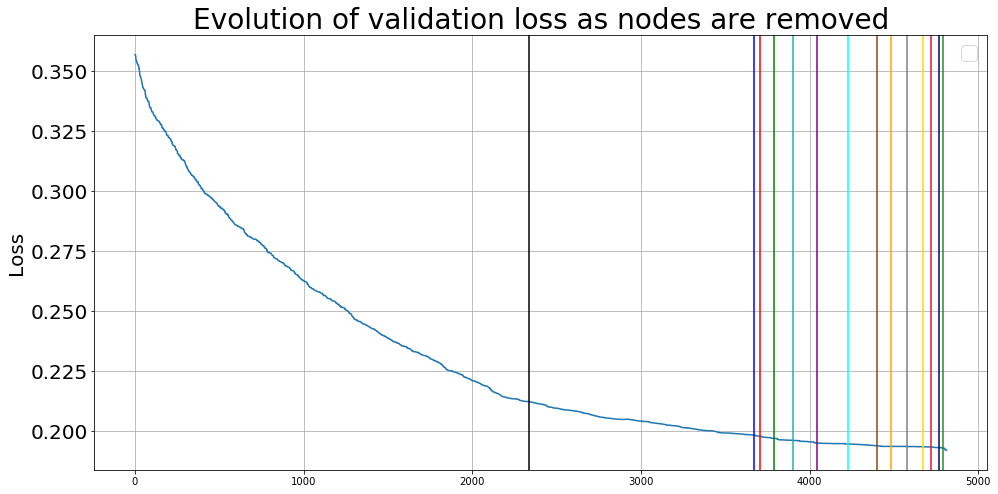

In [29]:
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(bls_val)
plt.title("Evolution of validation loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/Case_study/ev_loss_val.png")

No handles with labels found to put in legend.


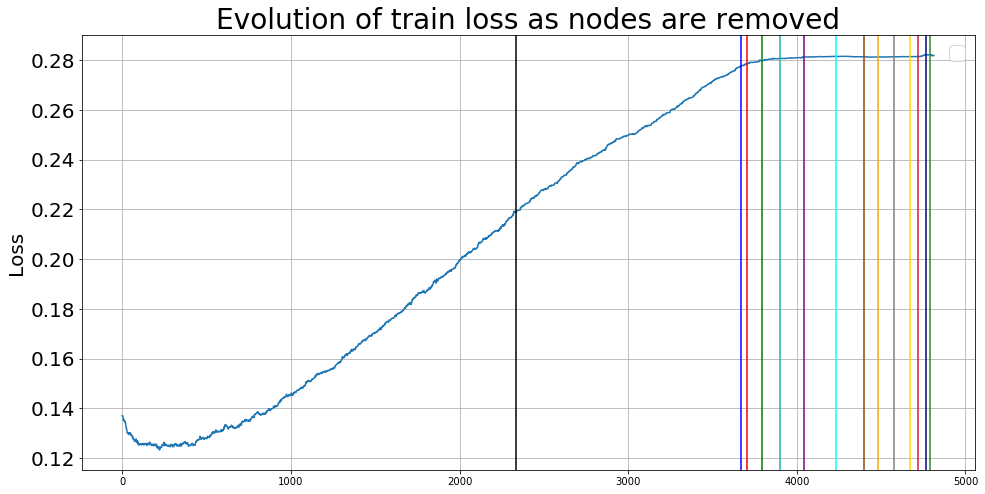

In [30]:
plt.plot(bls_train)
plt.title("Evolution of train loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/Case_study/ev_loss_train.png")

No handles with labels found to put in legend.


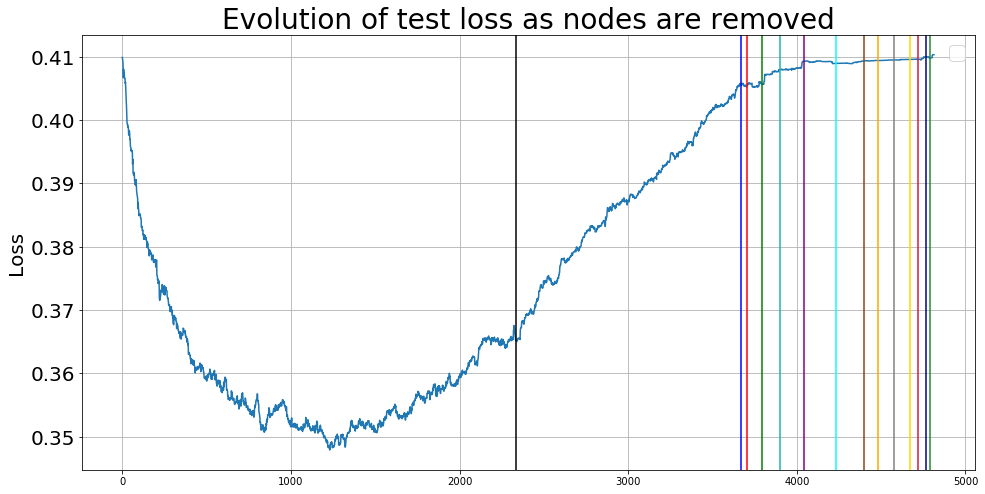

In [31]:
plt.plot(bls_test)
plt.title("Evolution of test loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/Case_study/ev_loss_test.png")

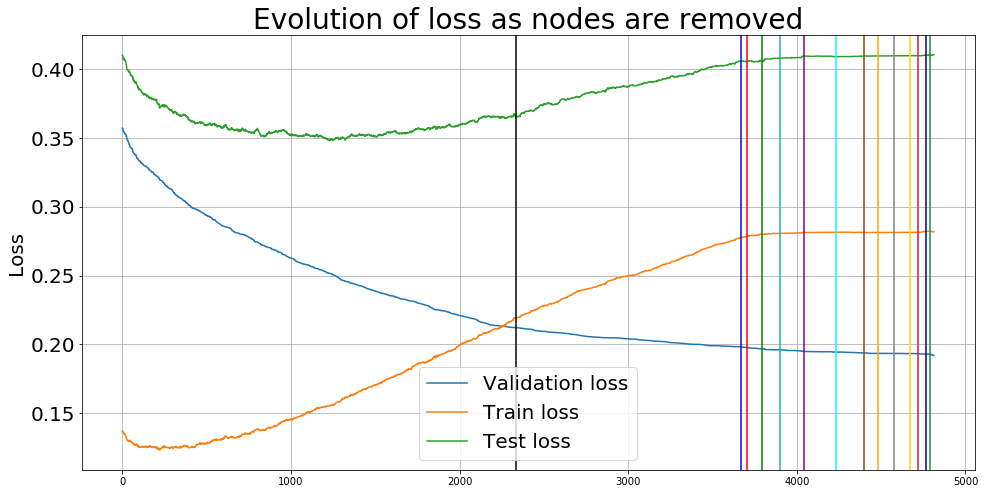

In [32]:
plt.plot(bls_val, label='Validation loss')
plt.plot(bls_train, label='Train loss')
plt.plot(bls_test, label='Test loss')
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/Case_study/ev_loss_all.png")

No handles with labels found to put in legend.


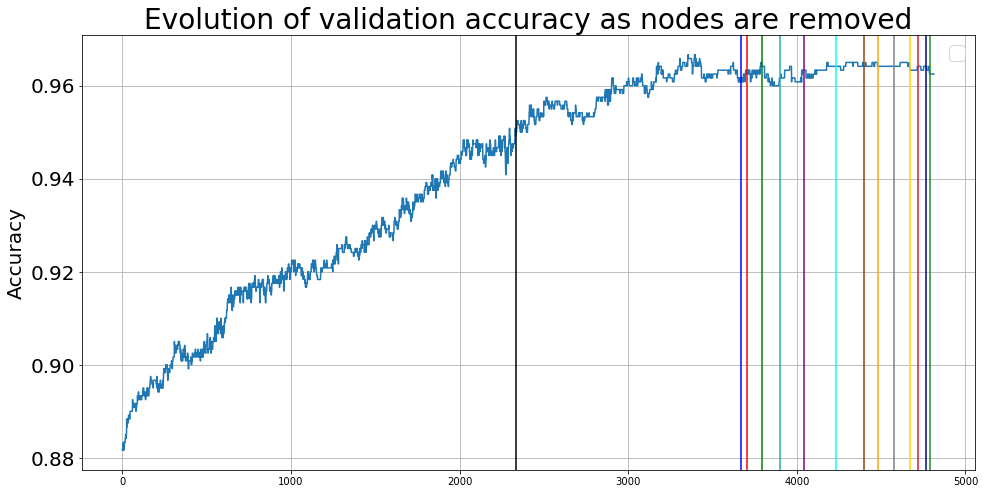

In [33]:
plt.plot(bas_val)
plt.title("Evolution of validation accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/Case_study/ev_accuracy_val.png")

No handles with labels found to put in legend.


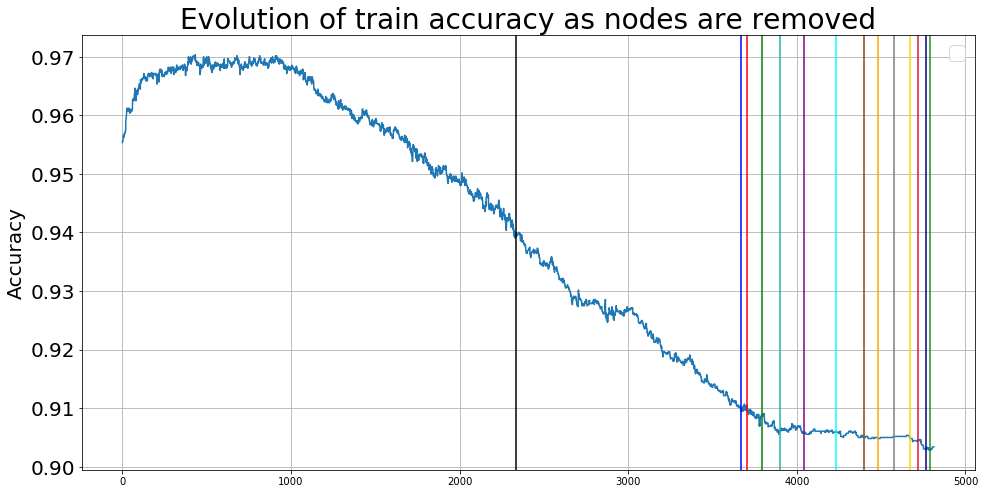

In [34]:
plt.plot(bas_train)
plt.title("Evolution of train accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/Case_study/ev_accuracy_train.png")

No handles with labels found to put in legend.


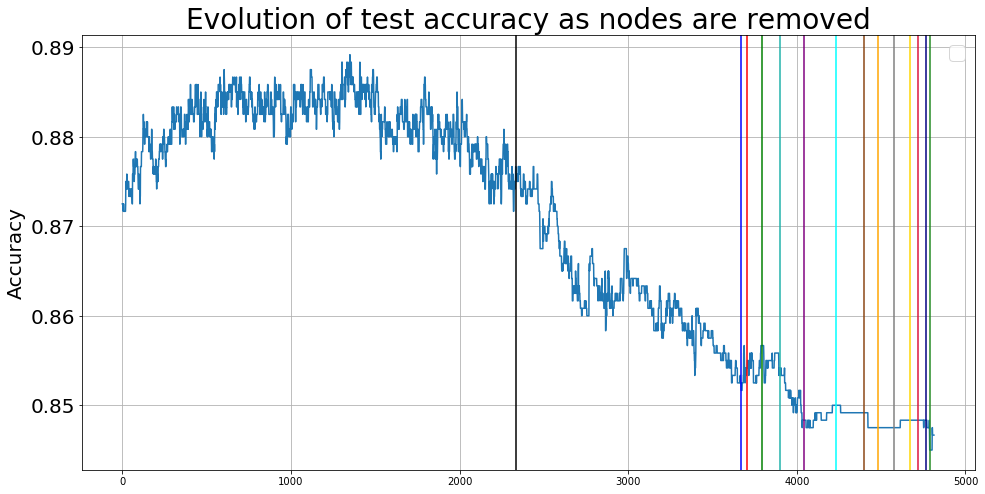

In [35]:
plt.plot(bas_test)
plt.title("Evolution of test accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/Case_study/ev_accuracy_test.png")

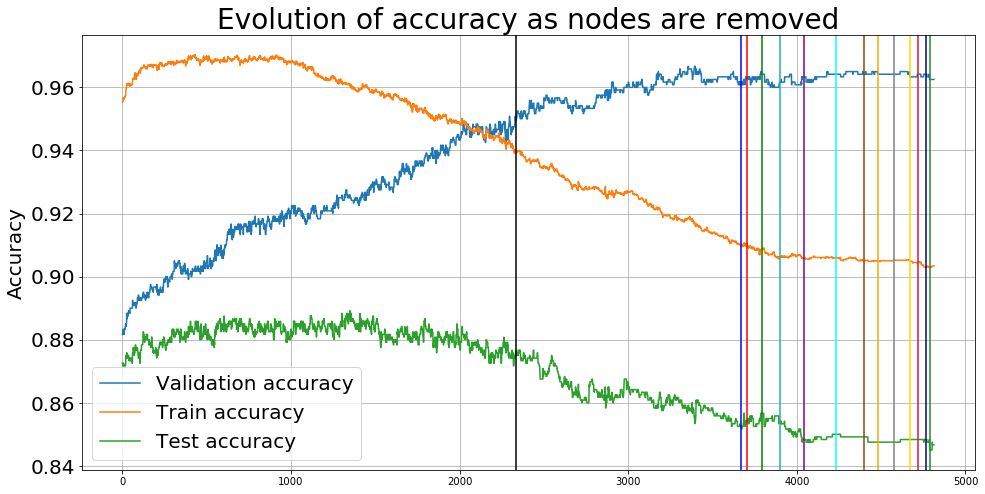

In [36]:
plt.plot(bas_val, label='Validation accuracy')
plt.plot(bas_train, label='Train accuracy')
plt.plot(bas_test, label='Test accuracy')
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/Case_study/ev_accuracy_all.png")

In [68]:
vgg16_test.load_weights('./Pruning/weights')

In [70]:
labels = np.array(list(test_ds.as_numpy_iterator()))[:,1]
y_test = np.zeros(1200)
i = 0
for label in labels:
    for l in label:
        y_test[i] = int(np.where(l)[0])
        i += 1

In [73]:
labels = np.array(list(val_ds.as_numpy_iterator()))[:,1]
y_val = np.zeros(1200)
i = 0
for label in labels:
    for l in label:
        y_val[i] = int(np.where(l)[0])
        i += 1

In [123]:
train_ds2 = train_ds.unbatch().take(5600)
data = np.array(list(train_ds2.as_numpy_iterator()))
labels = data[:,1]
xt = data[:,0]
x_train = np.zeros((5600, 224, 224, 3))
y_train = np.zeros(5600)
i = 0
for label in labels:
    y_train[i] = int(np.where(label)[0])
    i += 1
i = 0
for x in xt:
    x_train[i] = x
    i += 1

In [135]:
def confusion_matrix(true, pred, K):
    cm = np.zeros((K, K))
    for i in range(len(true)):
        cm[int(true[i]), int(pred[i])] += 1
    return cm

In [136]:
y_pred = vgg16.predict(test_ds)
K = 8
acc1 = []
yp = np.argmax(y_pred, axis=1)
for i in range(K):
    a = np.mean((yp[y_test == i] == y_test[y_test == i]))
    acc1.append(a)
acc1

[0.8,
 0.9,
 0.9133333333333333,
 0.94,
 0.9733333333333334,
 0.78,
 0.76,
 0.9133333333333333]

In [137]:
cm_test_old = confusion_matrix(y_test, yp, K)

In [138]:
y_pred = vgg16_test.predict(test_ds)
K = 8
acc1 = []
yp = np.argmax(y_pred, axis=1)
for i in range(K):
    a = np.mean((yp[y_test == i] == y_test[y_test == i]))
    acc1.append(a)
acc1

[0.7533333333333333,
 0.8466666666666667,
 0.7866666666666666,
 0.9666666666666667,
 0.96,
 0.8533333333333334,
 0.82,
 0.7866666666666666]

In [139]:
cm_test_new = confusion_matrix(y_test, yp, K)

In [140]:
y_pred = vgg16.predict(val_ds)
K = 8
acc1 = []
yp = np.argmax(y_pred, axis=1)
for i in range(K):
    a = np.mean((yp[y_val == i] == y_val[y_val == i]))
    acc1.append(a)
acc1

[0.74,
 0.88,
 0.9,
 0.9466666666666667,
 0.98,
 0.8,
 0.8733333333333333,
 0.9333333333333333]

In [141]:
cm_val_old = confusion_matrix(y_val, yp, K)

In [142]:
y_pred = vgg16_test.predict(val_ds)
K = 8
acc1 = []
yp = np.argmax(y_pred, axis=1)
for i in range(K):
    a = np.mean((yp[y_val == i] == y_val[y_val == i]))
    acc1.append(a)
acc1

[0.96,
 0.9933333333333333,
 0.8933333333333333,
 0.9933333333333333,
 0.9866666666666667,
 0.98,
 0.9533333333333334,
 0.94]

In [143]:
cm_val_new = confusion_matrix(y_val, yp, K)

In [144]:
y_pred = vgg16.predict(x_train)
K = 8
acc1 = []
yp = np.argmax(y_pred, axis=1)
for i in range(K):
    a = np.mean((yp[y_train == i] == y_train[y_train == i]))
    acc1.append(a)
acc1

[0.9728571428571429,
 0.9985714285714286,
 0.9542857142857143,
 0.99,
 0.9985714285714286,
 0.8828571428571429,
 0.8785714285714286,
 0.9671428571428572]

In [145]:
cm_train_old = confusion_matrix(y_train, yp, K)

In [146]:
y_pred = vgg16_test.predict(x_train)
K = 8
acc1 = []
yp = np.argmax(y_pred, axis=1)
for i in range(K):
    a = np.mean((yp[y_train == i] == y_train[y_train == i]))
    acc1.append(a)
acc1

[0.89,
 0.9357142857142857,
 0.8214285714285714,
 0.9671428571428572,
 0.98,
 0.8971428571428571,
 0.8557142857142858,
 0.88]

In [147]:
cm_train_new = confusion_matrix(y_train, yp, K)

In [154]:
cm_test_old

array([[120.,  28.,   0.,   0.,   0.,   0.,   1.,   1.],
       [ 13., 135.,   0.,   0.,   0.,   0.,   0.,   2.],
       [  0.,   0., 137.,   0.,   1.,  12.,   0.,   0.],
       [  0.,   0.,   0., 141.,   0.,   0.,   3.,   6.],
       [  0.,   0.,   1.,   0., 146.,   2.,   1.,   0.],
       [  0.,   0.,  30.,   0.,   2., 117.,   0.,   1.],
       [  0.,   0.,   0.,  17.,   1.,   0., 114.,  18.],
       [  0.,   1.,   0.,   5.,   1.,   0.,   6., 137.]])

In [155]:
cm_test_new

array([[113.,  34.,   0.,   0.,   0.,   0.,   1.,   2.],
       [ 20., 127.,   0.,   1.,   0.,   0.,   2.,   0.],
       [  0.,   0., 118.,   0.,   0.,  32.,   0.,   0.],
       [  0.,   0.,   0., 145.,   0.,   0.,   3.,   2.],
       [  0.,   0.,   0.,   0., 144.,   5.,   0.,   1.],
       [  0.,   0.,  17.,   0.,   4., 128.,   0.,   1.],
       [  1.,   0.,   0.,  17.,   0.,   0., 123.,   9.],
       [  3.,   0.,   0.,  13.,   3.,   0.,  13., 118.]])

In [156]:
cm_val_old

array([[111.,  33.,   0.,   0.,   0.,   0.,   3.,   3.],
       [ 16., 132.,   0.,   0.,   0.,   0.,   1.,   1.],
       [  0.,   0., 135.,   0.,   1.,  14.,   0.,   0.],
       [  0.,   0.,   0., 142.,   0.,   0.,   3.,   5.],
       [  0.,   0.,   2.,   0., 147.,   1.,   0.,   0.],
       [  0.,   0.,  25.,   0.,   5., 120.,   0.,   0.],
       [  0.,   0.,   0.,   6.,   2.,   0., 131.,  11.],
       [  0.,   0.,   0.,   3.,   1.,   1.,   5., 140.]])

In [157]:
cm_val_new

array([[144.,   5.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  1., 149.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., 134.,   0.,   0.,  16.,   0.,   0.],
       [  0.,   0.,   0., 149.,   0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0., 148.,   2.,   0.,   0.],
       [  0.,   0.,   3.,   0.,   0., 147.,   0.,   0.],
       [  0.,   0.,   0.,   6.,   0.,   0., 143.,   1.],
       [  0.,   0.,   0.,   6.,   1.,   1.,   1., 141.]])

In [158]:
cm_train_old

array([[681.,  19.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  1., 699.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., 668.,   0.,   1.,  31.,   0.,   0.],
       [  0.,   0.,   0., 693.,   0.,   0.,   0.,   7.],
       [  1.,   0.,   0.,   0., 699.,   0.,   0.,   0.],
       [  0.,   0.,  75.,   0.,   7., 618.,   0.,   0.],
       [  0.,   0.,   0.,  38.,   2.,   0., 615.,  45.],
       [  0.,   0.,   0.,  15.,   6.,   0.,   2., 677.]])

In [159]:
cm_train_new

array([[623.,  74.,   0.,   1.,   0.,   0.,   1.,   1.],
       [ 44., 655.,   0.,   0.,   0.,   0.,   1.,   0.],
       [  0.,   0., 575.,   0.,   5., 120.,   0.,   0.],
       [  0.,   0.,   0., 677.,   0.,   0.,  14.,   9.],
       [  1.,   0.,   3.,   0., 686.,   9.,   0.,   1.],
       [  0.,   0.,  69.,   0.,   3., 628.,   0.,   0.],
       [  3.,   0.,   0.,  56.,   2.,   3., 599.,  37.],
       [  2.,   0.,   0.,  45.,  11.,   1.,  25., 616.]])

In [27]:
import tqdm
from hfunc import models
import pandas as pd
from sklearn.model_selection import train_test_split

In [28]:
np.random.seed(2020)

In [29]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [18]:
trials = 100
accs = []
losses = []
for trial in tqdm.trange(trials):
    model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    accs += [a]
    losses += [l]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:09<00:00,  6.70s/it]


In [23]:
A = pd.Series(accs)
A.to_csv('../../../results/train_vs_val/mnist_acc_train_ANN.csv')
A.describe()

count    100.000000
mean       0.976617
std        0.001405
min        0.972500
25%        0.975775
50%        0.976700
75%        0.977425
max        0.980500
dtype: float64

In [24]:
L = pd.Series(losses)
L.to_csv('../../../results/train_vs_val/mnist_loss_train_ANN.csv')
L.describe()

count    100.000000
mean       0.076410
std        0.004550
min        0.066926
25%        0.072968
50%        0.076279
75%        0.079789
max        0.087369
dtype: float64

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [31]:
trials = 100
accs = []
losses = []
for trial in tqdm.trange(trials):
    model, r = models.train_basic_ANN(x_train, y_train, 128, (x_test, y_test), epochs=5)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    accs += [a]
    losses += [l]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [12:47<00:00,  7.67s/it]


In [32]:
A = pd.Series(accs)
A.to_csv('../../../results/train_vs_val/mnist_acc_val_ANN.csv')
A.describe()

count    100.000000
mean       0.975208
std        0.001507
min        0.969200
25%        0.974400
50%        0.975400
75%        0.976125
max        0.978500
dtype: float64

In [33]:
L = pd.Series(losses)
L.to_csv('../../../results/train_vs_val/mnist_loss_val_ANN.csv')
L.describe()

count    100.000000
mean       0.080928
std        0.004478
min        0.071837
25%        0.077626
50%        0.080841
75%        0.084048
max        0.091864
dtype: float64

In [34]:
np.random.seed(2020)

In [35]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [36]:
trials = 100
accs = []
losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    accs += [a]
    losses += [l]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:03<00:00,  6.64s/it]


In [37]:
A = pd.Series(accs)
A.to_csv('../../../results/train_vs_val/fmnist_acc_train_MLP.csv')
A.describe()

count    100.000000
mean       0.871236
std        0.006458
min        0.843100
25%        0.868375
50%        0.872500
75%        0.875525
max        0.880200
dtype: float64

In [38]:
L = pd.Series(losses)
L.to_csv('../../../results/train_vs_val/fmnist_loss_train_MLP.csv')
L.describe()

count    100.000000
mean       0.358478
std        0.019125
min        0.334216
25%        0.346957
50%        0.353542
75%        0.364159
max        0.448258
dtype: float64

In [39]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [41]:
trials = 100
accs = []
losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    accs += [a]
    losses += [l]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:51<00:00,  7.12s/it]


In [42]:
A = pd.Series(accs)
A.to_csv('../../../results/train_vs_val/fmnist_acc_val_MLP.csv')
A.describe()

count    100.000000
mean       0.869503
std        0.004725
min        0.855300
25%        0.866650
50%        0.869900
75%        0.873500
max        0.877100
dtype: float64

In [43]:
L = pd.Series(losses)
L.to_csv('../../../results/train_vs_val/fmnist_loss_val_MLP.csv')
L.describe()

count    100.000000
mean       0.364003
std        0.013097
min        0.342142
25%        0.354748
50%        0.362130
75%        0.372217
max        0.407479
dtype: float64

In [44]:
np.random.seed(2020)

In [45]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [46]:
trials = 100
accs = []
losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    accs += [a]
    losses += [l]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [24:24<00:00, 14.65s/it]


In [47]:
A = pd.Series(accs)
A.to_csv('../../../results/train_vs_val/cifar_acc_train_CNN.csv')
A.describe()

count    100.000000
mean       0.737093
std        0.007416
min        0.716400
25%        0.733450
50%        0.737450
75%        0.741775
max        0.755800
dtype: float64

In [48]:
L = pd.Series(losses)
L.to_csv('../../../results/train_vs_val/cifar_loss_train_CNN.csv')
L.describe()

count    100.000000
mean       0.790415
std        0.022921
min        0.747141
25%        0.772150
50%        0.788718
75%        0.804259
max        0.866115
dtype: float64

In [49]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [50]:
trials = 100
accs = []
losses = []
for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    accs += [a]
    losses += [l]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [20:53<00:00, 12.54s/it]


In [51]:
A = pd.Series(accs)
A.to_csv('../../../results/train_vs_val/cifar_acc_val_CNN.csv')
A.describe()

count    100.000000
mean       0.725961
std        0.009754
min        0.692800
25%        0.721325
50%        0.727850
75%        0.732025
max        0.745700
dtype: float64

In [52]:
L = pd.Series(losses)
L.to_csv('../../../results/train_vs_val/cifar_loss_val_CNN.csv')
L.describe()

count    100.000000
mean       0.821621
std        0.034031
min        0.763188
25%        0.802565
50%        0.815224
75%        0.840417
max        0.964112
dtype: float64